# Classifiers - low vs high complexity - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds, checkIfValid=True):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            if checkIfValid and not(tmpBR['br_ok'][0]):
                # don't add this to the data that will be returned
                # by going to the next iteration
                continue
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [11]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    if (y.shape[0] <= 0):
        idents.remove(ident)
        print(ident)
        continue
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

In [12]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, data3, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])
        
    #plot data3 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data3[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

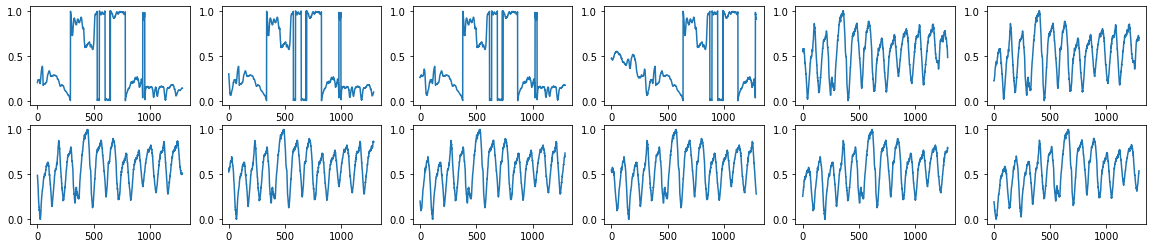

<Figure size 432x288 with 0 Axes>

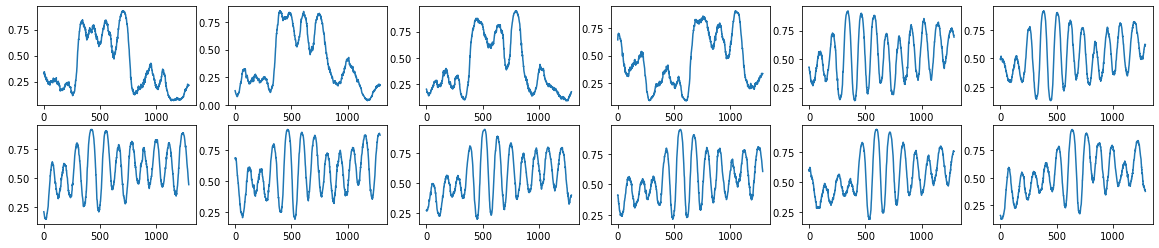

<Figure size 432x288 with 0 Axes>

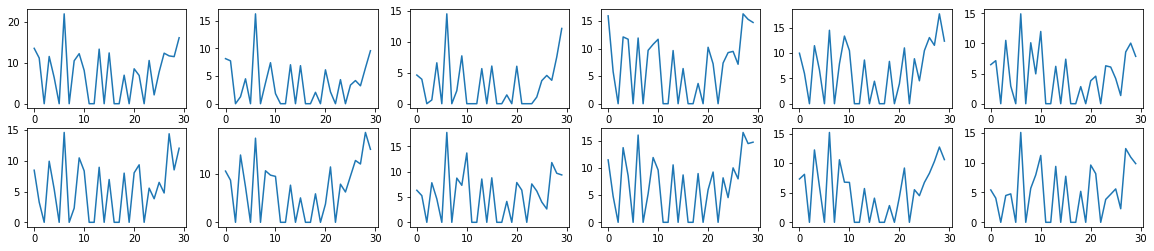

In [17]:
data2 = uc_ae.predict(phase_all_valid)
data3 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [18]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [20]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

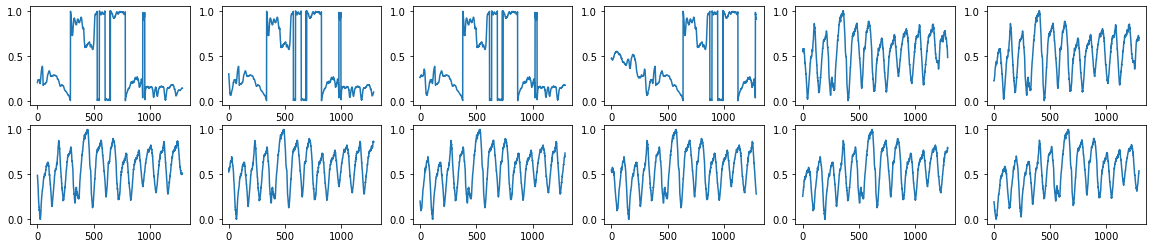

<Figure size 432x288 with 0 Axes>

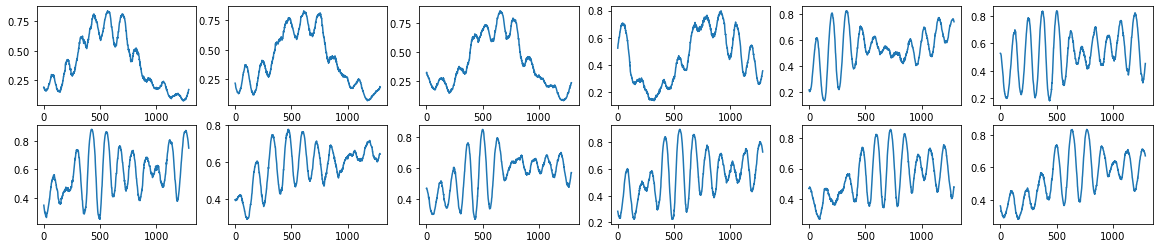

<Figure size 432x288 with 0 Axes>

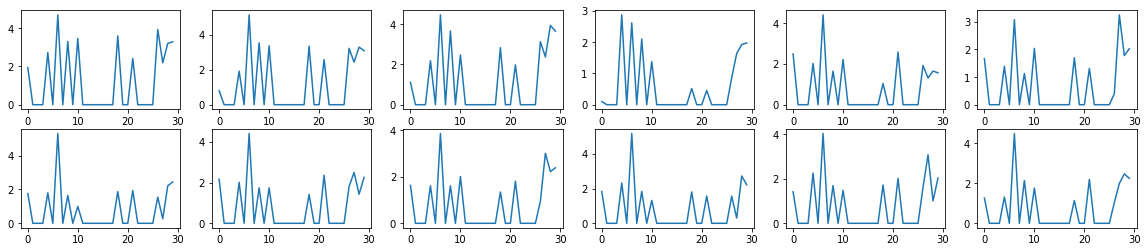

In [21]:
data2 = sp_ae.predict(phase_all_valid)
data3 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [22]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [23]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [24]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

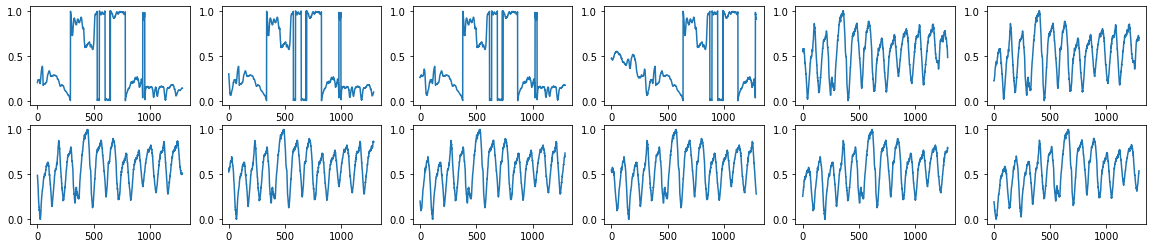

<Figure size 432x288 with 0 Axes>

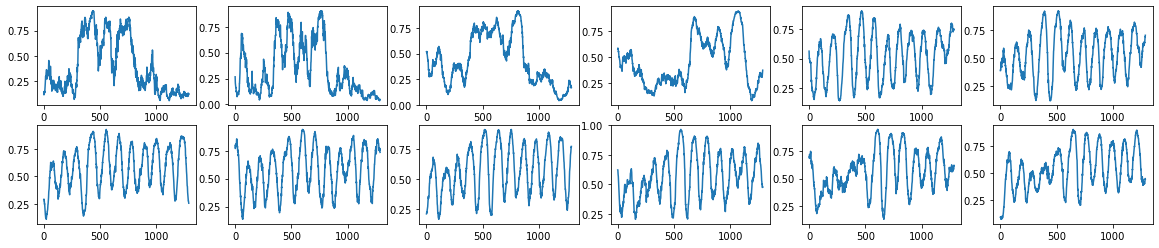

<Figure size 432x288 with 0 Axes>

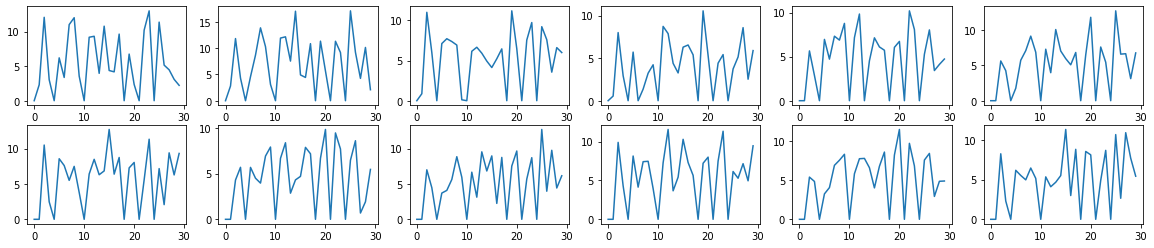

In [25]:
data2 = de_ae.predict(phase_all_valid)
data3 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [26]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [27]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [28]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [29]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [30]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [31]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [32]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [33]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:35.283420
iteration: 3 of 23 ; time elapsed: 0:01:10.473818
iteration: 4 of 23 ; time elapsed: 0:01:45.930874
iteration: 5 of 23 ; time elapsed: 0:02:21.165553
iteration: 6 of 23 ; time elapsed: 0:02:57.173711
iteration: 7 of 23 ; time elapsed: 0:03:32.311109
iteration: 8 of 23 ; time elapsed: 0:04:08.037094
iteration: 9 of 23 ; time elapsed: 0:04:46.247025
iteration: 10 of 23 ; time elapsed: 0:05:30.756606
iteration: 11 of 23 ; time elapsed: 0:06:09.988349
iteration: 12 of 23 ; time elapsed: 0:06:44.706666
iteration: 13 of 23 ; time elapsed: 0:07:19.434613
iteration: 14 of 23 ; time elapsed: 0:07:54.097193
iteration: 15 of 23 ; time elapsed: 0:08:29.190082
iteration: 16 of 23 ; time elapsed: 0:09:04.303996
iteration: 17 of 23 ; time elapsed: 0:09:39.243798
iteration: 18 of 23 ; time elapsed: 0:10:14.762654
iteration: 19 of 23 ; time elapsed: 0:10:49.214265
iteration: 20 of 23 ; time elapsed: 0:11:23.948

In [34]:
accuracies['simple_dense'] = accs

In [35]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.224490,0.326531,0.673469,0.775510,0.244898,0.224490,0.387755,62i9y
1,0.432099,0.555556,0.456790,0.543210,0.493827,0.432099,0.580247,2gu87
2,0.337662,0.415584,0.402597,0.480519,0.246753,0.467532,0.402597,iz2ps
3,0.539326,0.505618,0.314607,0.539326,0.539326,0.516854,0.494382,1mpau
4,0.345238,0.285714,0.607143,0.535714,0.535714,0.416667,0.476190,7dwjy
5,0.516949,0.474576,0.330508,0.601695,0.525424,0.525424,0.415254,7swyk
6,0.514706,0.632353,0.308824,0.632353,0.573529,0.632353,0.573529,94mnx
7,0.480769,0.557692,0.538462,0.384615,0.615385,0.596154,0.384615,bd47a
8,0.550000,0.310000,0.550000,0.400000,0.420000,0.470000,0.510000,c24ur
9,0.452055,0.424658,0.424658,0.342466,0.410959,0.547945,0.424658,ctsax


In [36]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.224490   0.285714   0.308824        0.342466       0.244898  0.224490  0.357798
max     0.930233   0.632353   0.684211        0.790123       0.930233  0.767442  0.827586
mean    0.526804   0.476876   0.493455        0.525677       0.550047  0.547954  0.538952
median  0.518987   0.474576   0.532110        0.535088       0.539326  0.559633  0.510000


#### LSTM-based classifier  
based on the original author's code

In [37]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [38]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [39]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [40]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:02:26.634220
iteration: 3 of 23 ; time elapsed: 0:04:53.653677
iteration: 4 of 23 ; time elapsed: 0:07:23.095244
iteration: 5 of 23 ; time elapsed: 0:09:51.423997
iteration: 6 of 23 ; time elapsed: 0:12:19.788800
iteration: 7 of 23 ; time elapsed: 0:14:42.138513
iteration: 8 of 23 ; time elapsed: 0:17:16.758279
iteration: 9 of 23 ; time elapsed: 0:19:50.702482
iteration: 10 of 23 ; time elapsed: 0:22:24.607480
iteration: 11 of 23 ; time elapsed: 0:25:02.090958
iteration: 12 of 23 ; time elapsed: 0:27:44.788608
iteration: 13 of 23 ; time elapsed: 0:30:18.874852
iteration: 14 of 23 ; time elapsed: 0:32:55.010745
iteration: 15 of 23 ; time elapsed: 0:35:25.587735
iteration: 16 of 23 ; time elapsed: 0:37:55.653290
iteration: 17 of 23 ; time elapsed: 0:40:28.352036
iteration: 18 of 23 ; time elapsed: 0:43:23.040116
iteration: 19 of 23 ; time elapsed: 0:46:06.273844
iteration: 20 of 23 ; time elapsed: 0:48:40.522

In [42]:
accuracies['LSTM'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.551020,0.632653,0.612245,0.591837,0.244898,0.346939,0.326531,62i9y
1,0.481481,0.530864,0.493827,0.518519,0.481481,0.481481,0.518519,2gu87
2,0.337662,0.506494,0.519481,0.519481,0.298701,0.389610,0.402597,iz2ps
3,0.494382,0.494382,0.494382,0.505618,0.471910,0.606742,0.483146,1mpau
4,0.476190,0.511905,0.440476,0.547619,0.523810,0.571429,0.452381,7dwjy
5,0.627119,0.449153,0.423729,0.398305,0.533898,0.449153,0.245763,7swyk
6,0.573529,0.602941,0.426471,0.602941,0.632353,0.602941,0.573529,94mnx
7,0.538462,0.423077,0.461538,0.173077,0.403846,0.480769,0.480769,bd47a
8,0.530000,0.490000,0.430000,0.470000,0.550000,0.420000,0.590000,c24ur
9,0.589041,0.602740,0.369863,0.493151,0.575342,0.589041,0.616438,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.337662   0.325581   0.250000        0.173077       0.244898  0.346939  0.245763
max     0.707865   0.632653   0.666667        0.670886       0.666667  0.879310  0.672414
mean    0.555860   0.496762   0.488518        0.480755       0.499641  0.545993  0.493564
median  0.556701   0.495327   0.493827        0.493151       0.518987  0.546392  0.500000


#### kNN

In [45]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [46]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [47]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [48]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [49]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.205480
iteration: 3 of 23 ; time elapsed: 0:00:00.424102
iteration: 4 of 23 ; time elapsed: 0:00:00.626279
iteration: 5 of 23 ; time elapsed: 0:00:00.838785
iteration: 6 of 23 ; time elapsed: 0:00:01.038219
iteration: 7 of 23 ; time elapsed: 0:00:01.257632
iteration: 8 of 23 ; time elapsed: 0:00:01.459325
iteration: 9 of 23 ; time elapsed: 0:00:01.653443
iteration: 10 of 23 ; time elapsed: 0:00:01.862886
iteration: 11 of 23 ; time elapsed: 0:00:02.062419
iteration: 12 of 23 ; time elapsed: 0:00:02.270092
iteration: 13 of 23 ; time elapsed: 0:00:02.474148
iteration: 14 of 23 ; time elapsed: 0:00:02.677604
iteration: 15 of 23 ; time elapsed: 0:00:02.880030
iteration: 16 of 23 ; time elapsed: 0:00:03.091444
iteration: 17 of 23 ; time elapsed: 0:00:03.323799
iteration: 18 of 23 ; time elapsed: 0:00:03.515287
iteration: 19 of 23 ; time elapsed: 0:00:03.709396
iteration: 20 of 23 ; time elapsed: 0:00:03.903

In [51]:
accuracies['kNN'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.326531,0.367347,0.489796,0.428571,0.306122,0.387755,0.306122,62i9y
1,0.641975,0.604938,0.432099,0.617284,0.432099,0.530864,0.444444,2gu87
2,0.467532,0.480519,0.285714,0.480519,0.337662,0.376623,0.246753,iz2ps
3,0.561798,0.505618,0.662921,0.539326,0.573034,0.640449,0.483146,1mpau
4,0.440476,0.440476,0.559524,0.583333,0.583333,0.630952,0.607143,7dwjy
5,0.483051,0.466102,0.449153,0.440678,0.398305,0.423729,0.627119,7swyk
6,0.485294,0.470588,0.529412,0.602941,0.647059,0.647059,0.514706,94mnx
7,0.634615,0.480769,0.461538,0.211538,0.634615,0.557692,0.500000,bd47a
8,0.600000,0.400000,0.550000,0.560000,0.520000,0.520000,0.560000,c24ur
9,0.630137,0.424658,0.534247,0.589041,0.698630,0.356164,0.438356,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.326531   0.333333   0.285714        0.206897       0.306122  0.356164  0.246753
max     0.755814   0.651163   0.662921        0.721649       0.758621  0.689655  0.651163
mean    0.536686   0.461065   0.485188        0.519919       0.520586  0.532619  0.498839
median  0.531250   0.466102   0.493671        0.560000       0.528090  0.541667  0.513761


####  SVC

In [54]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [55]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [56]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [57]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [58]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:04.795039
iteration: 3 of 23 ; time elapsed: 0:00:09.494297
iteration: 4 of 23 ; time elapsed: 0:00:14.205034
iteration: 5 of 23 ; time elapsed: 0:00:18.959663
iteration: 6 of 23 ; time elapsed: 0:00:23.483425
iteration: 7 of 23 ; time elapsed: 0:00:28.189906
iteration: 8 of 23 ; time elapsed: 0:00:33.162471
iteration: 9 of 23 ; time elapsed: 0:00:37.828452
iteration: 10 of 23 ; time elapsed: 0:00:42.460013
iteration: 11 of 23 ; time elapsed: 0:00:47.058426
iteration: 12 of 23 ; time elapsed: 0:00:51.799191
iteration: 13 of 23 ; time elapsed: 0:00:56.832097
iteration: 14 of 23 ; time elapsed: 0:01:01.774939
iteration: 15 of 23 ; time elapsed: 0:01:06.734023
iteration: 16 of 23 ; time elapsed: 0:01:11.396957
iteration: 17 of 23 ; time elapsed: 0:01:16.395811
iteration: 18 of 23 ; time elapsed: 0:01:21.522939
iteration: 19 of 23 ; time elapsed: 0:01:26.430358
iteration: 20 of 23 ; time elapsed: 0:01:31.112

In [60]:
accuracies['SVC'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.265306,0.469388,0.448980,0.408163,0.306122,0.285714,0.387755,62i9y
1,0.493827,0.580247,0.555556,0.444444,0.419753,0.419753,0.518519,2gu87
2,0.402597,0.337662,0.402597,0.324675,0.389610,0.363636,0.402597,iz2ps
3,0.617978,0.460674,0.516854,0.595506,0.662921,0.561798,0.494382,1mpau
4,0.559524,0.500000,0.583333,0.500000,0.666667,0.547619,0.464286,7dwjy
5,0.432203,0.423729,0.466102,0.415254,0.550847,0.525424,0.415254,7swyk
6,0.602941,0.558824,0.426471,0.441176,0.558824,0.529412,0.573529,94mnx
7,0.596154,0.557692,0.461538,0.326923,0.615385,0.519231,0.480769,bd47a
8,0.490000,0.360000,0.410000,0.440000,0.510000,0.490000,0.590000,c24ur
9,0.493151,0.684932,0.410959,0.383562,0.575342,0.465753,0.602740,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.265306   0.337662   0.162791        0.310345       0.306122  0.285714  0.381443
max     0.837209   0.684932   0.715596        0.740741       0.906977  0.793103  0.720930
mean    0.554563   0.501202   0.484302        0.486879       0.575078  0.548657  0.515218
median  0.559524   0.477064   0.466102        0.444444       0.558824  0.529412  0.494382


#### Random Forest

In [63]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [64]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [65]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [66]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [67]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [68]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:07.844384
iteration: 3 of 23 ; time elapsed: 0:00:15.457795
iteration: 4 of 23 ; time elapsed: 0:00:22.919820
iteration: 5 of 23 ; time elapsed: 0:00:30.539860
iteration: 6 of 23 ; time elapsed: 0:00:37.818318
iteration: 7 of 23 ; time elapsed: 0:00:45.194998
iteration: 8 of 23 ; time elapsed: 0:00:53.086867
iteration: 9 of 23 ; time elapsed: 0:01:00.874330
iteration: 10 of 23 ; time elapsed: 0:01:08.543820
iteration: 11 of 23 ; time elapsed: 0:01:16.288601
iteration: 12 of 23 ; time elapsed: 0:01:24.060748
iteration: 13 of 23 ; time elapsed: 0:01:32.063976
iteration: 14 of 23 ; time elapsed: 0:01:39.941668
iteration: 15 of 23 ; time elapsed: 0:01:47.477381
iteration: 16 of 23 ; time elapsed: 0:01:54.872642
iteration: 17 of 23 ; time elapsed: 0:02:02.626435
iteration: 18 of 23 ; time elapsed: 0:02:10.713107
iteration: 19 of 23 ; time elapsed: 0:02:18.607313
iteration: 20 of 23 ; time elapsed: 0:02:26.335

In [69]:
accuracies['random_forest'] = accs

In [70]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.224490,0.408163,0.571429,0.265306,0.367347,0.387755,0.408163,62i9y
1,0.469136,0.407407,0.407407,0.407407,0.432099,0.469136,0.506173,2gu87
2,0.272727,0.532468,0.350649,0.467532,0.298701,0.350649,0.415584,iz2ps
3,0.573034,0.494382,0.539326,0.516854,0.449438,0.415730,0.370787,1mpau
4,0.345238,0.452381,0.535714,0.488095,0.607143,0.571429,0.511905,7dwjy
5,0.347458,0.474576,0.525424,0.508475,0.440678,0.415254,0.457627,7swyk
6,0.500000,0.514706,0.544118,0.558824,0.500000,0.617647,0.602941,94mnx
7,0.500000,0.673077,0.615385,0.557692,0.538462,0.461538,0.615385,bd47a
8,0.510000,0.390000,0.500000,0.400000,0.490000,0.440000,0.480000,c24ur
9,0.410959,0.506849,0.410959,0.397260,0.561644,0.589041,0.643836,ctsax


In [71]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.224490   0.344828   0.222222        0.265306       0.244186  0.220930  0.255814
max     0.827586   0.697674   0.783505        0.744186       0.706897  0.721519  0.763158
mean    0.482440   0.499123   0.496023        0.496440       0.500322  0.511265  0.528346
median  0.500000   0.488372   0.535088        0.476636       0.500000  0.484536  0.506173


#### Naive Bayesian

In [72]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [73]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [74]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.193529
iteration: 3 of 23 ; time elapsed: 0:00:00.393714
iteration: 4 of 23 ; time elapsed: 0:00:00.579759
iteration: 5 of 23 ; time elapsed: 0:00:00.776199
iteration: 6 of 23 ; time elapsed: 0:00:00.955747
iteration: 7 of 23 ; time elapsed: 0:00:01.140225
iteration: 8 of 23 ; time elapsed: 0:00:01.331742
iteration: 9 of 23 ; time elapsed: 0:00:01.523827
iteration: 10 of 23 ; time elapsed: 0:00:01.709979
iteration: 11 of 23 ; time elapsed: 0:00:01.887640
iteration: 12 of 23 ; time elapsed: 0:00:02.062739
iteration: 13 of 23 ; time elapsed: 0:00:02.239243
iteration: 14 of 23 ; time elapsed: 0:00:02.415796
iteration: 15 of 23 ; time elapsed: 0:00:02.585337
iteration: 16 of 23 ; time elapsed: 0:00:02.753894
iteration: 17 of 23 ; time elapsed: 0:00:02.923017
iteration: 18 of 23 ; time elapsed: 0:00:03.107007
iteration: 19 of 23 ; time elapsed: 0:00:03.285498
iteration: 20 of 23 ; time elapsed: 0:00:03.460

In [75]:
accuracies['naive_bayesian'] = accs

In [76]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.285714,0.265306,0.285714,0.285714,0.285714,0.408163,0.510204,62i9y
1,0.518519,0.580247,0.481481,0.481481,0.518519,0.506173,0.518519,2gu87
2,0.467532,0.259740,0.597403,0.597403,0.584416,0.415584,0.402597,iz2ps
3,0.325843,0.505618,0.550562,0.550562,0.438202,0.471910,0.483146,1mpau
4,0.416667,0.523810,0.476190,0.476190,0.583333,0.488095,0.476190,7dwjy
5,0.415254,0.389831,0.508475,0.508475,0.584746,0.415254,0.491525,7swyk
6,0.367647,0.382353,0.397059,0.397059,0.367647,0.617647,0.602941,94mnx
7,0.442308,0.807692,0.346154,0.346154,0.403846,0.480769,0.653846,bd47a
8,0.490000,0.540000,0.410000,0.410000,0.210000,0.590000,0.590000,c24ur
9,0.136986,0.328767,0.315068,0.315068,0.273973,0.410959,0.684932,ctsax


In [77]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.136986   0.259740   0.258621        0.285714       0.210000  0.408163  0.302326
max     0.790698   0.807692   0.697674        0.697674       0.783505  0.844828  0.689655
mean    0.473467   0.519647   0.475187        0.496417       0.501907  0.558024  0.525046
median  0.489583   0.540000   0.493671        0.508475       0.518519  0.550459  0.510204


#### XGBoost

In [78]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [79]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [80]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [81]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [82]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [83]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:06.930744
iteration: 3 of 23 ; time elapsed: 0:00:13.503988
iteration: 4 of 23 ; time elapsed: 0:00:19.879791
iteration: 5 of 23 ; time elapsed: 0:00:26.433001
iteration: 6 of 23 ; time elapsed: 0:00:32.322147
iteration: 7 of 23 ; time elapsed: 0:00:38.479610
iteration: 8 of 23 ; time elapsed: 0:00:45.380594
iteration: 9 of 23 ; time elapsed: 0:00:52.091950
iteration: 10 of 23 ; time elapsed: 0:00:58.759403
iteration: 11 of 23 ; time elapsed: 0:01:05.329272
iteration: 12 of 23 ; time elapsed: 0:01:11.791591
iteration: 13 of 23 ; time elapsed: 0:01:18.488316
iteration: 14 of 23 ; time elapsed: 0:01:25.466203
iteration: 15 of 23 ; time elapsed: 0:01:32.139805
iteration: 16 of 23 ; time elapsed: 0:01:38.753666
iteration: 17 of 23 ; time elapsed: 0:01:45.770453
iteration: 18 of 23 ; time elapsed: 0:01:53.382131
iteration: 19 of 23 ; time elapsed: 0:02:00.396703
iteration: 20 of 23 ; time elapsed: 0:02:06.543

In [84]:
accuracies['XGBoost'] = accs

In [85]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.244898,0.530612,0.489796,0.367347,0.346939,0.285714,0.346939,62i9y
1,0.518519,0.530864,0.419753,0.382716,0.506173,0.444444,0.580247,2gu87
2,0.415584,0.376623,0.337662,0.519481,0.389610,0.519481,0.454545,iz2ps
3,0.550562,0.662921,0.471910,0.505618,0.494382,0.460674,0.393258,1mpau
4,0.357143,0.535714,0.511905,0.547619,0.476190,0.488095,0.511905,7dwjy
5,0.423729,0.627119,0.550847,0.610169,0.415254,0.440678,0.415254,7swyk
6,0.470588,0.544118,0.514706,0.617647,0.544118,0.602941,0.558824,94mnx
7,0.538462,0.403846,0.750000,0.461538,0.538462,0.461538,0.615385,bd47a
8,0.470000,0.430000,0.490000,0.310000,0.380000,0.370000,0.340000,c24ur
9,0.452055,0.438356,0.342466,0.520548,0.616438,0.520548,0.589041,ctsax


In [86]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.244898   0.376623   0.194444        0.310000       0.313953  0.220930  0.340000
max     0.655172   0.662921   0.750000        0.641304       0.758621  0.746835  0.675439
mean    0.498105   0.508898   0.469771        0.490932       0.497275  0.500055  0.518460
median  0.511628   0.513889   0.489796        0.505618       0.506173  0.488095  0.525773


###  Compare Accuracies

Save all accuracies to results csv file:

In [88]:
results_path = "results/LvH/LvH-all.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [89]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.224490   0.285714   0.308824        0.342466       0.244898  0.224490  0.357798
max     0.930233   0.632353   0.684211        0.790123       0.930233  0.767442  0.827586
mean    0.526804   0.476876   0.493455        0.525677       0.550047  0.547954  0.538952
median  0.518987   0.474576   0.532110        0.535088       0.539326  0.559633  0.510000


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.337662   0.325581   0.250000        0.173077       0.244898  0.346939  0.245763
max     0.707865   0.632653   0.666667        0.670886       0.666667  0.879310  0.672414
mean    0.555860   0.496762   0.488518        0.480755       0.499641  0.545993  0.493564
median  0.556701   0.495327   0.493827        0.493151       0.518987  0.546392  0.500000


----------- kNN: -----------

Print all accuracies in table form:

In [90]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.224490   0.326531   0.673469        0.775510       0.244898  0.224490  0.387755   62i9y
1   0.432099   0.555556   0.456790        0.543210       0.493827  0.432099  0.580247   2gu87
2   0.337662   0.415584   0.402597        0.480519       0.246753  0.467532  0.402597   iz2ps
3   0.539326   0.505618   0.314607        0.539326       0.539326  0.516854  0.494382   1mpau
4   0.345238   0.285714   0.607143        0.535714       0.535714  0.416667  0.476190   7dwjy
5   0.516949   0.474576   0.330508        0.601695       0.525424  0.525424  0.415254   7swyk
6   0.514706   0.632353   0.308824        0.632353       0.573529  0.632353  0.573529   94mnx
7   0.480769   0.557692   0.538462        0.384615       0.615385  0.596154  0.384615   bd47a
8   0.550000   0.310000   0.550000        0.400000       0.420000  0.470000  0.510000   c24ur
9   0.452055   0.424658   0.424658        0.34